# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных:

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).

Задачи:

- Загрузить и подготовь данные. 
- Обучить и проверить модель для каждого региона.
- Подготовить данные к расчёту прибыли.
- Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.
- Посчитать риски и прибыль для каждого региона.
- Написать выводы: предложить регион для разработки скважин.

In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik
!pip install -U pip
!pip install -U Pillow
!pip install matplotlib==3.7.3
!pip install numba==0.58.1
!pip install ydata_profiling -U

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ydata_profiling as ydp
from phik.report import plot_correlation_matrix 
from phik import report
from scipy import stats as st
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42

     |████████████████████████████████| 1.8 MB 1.3 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 29.6 MB/s eta 0:00:00
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 60.4 MB/s eta 0:00:00 0:00:01
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Загрузка и подготовка данных

In [2]:
pth1 = '/datasets/geo_data_0.csv'
pth2 = 'https://code.s3.yandex.net/datasets/geo_data_0.csv'

if os.path.exists(pth1):
    data_0 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_0 = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
display(data_0.head())
data_0.info()

id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [3]:
pth3 = '/datasets/geo_data_1.csv'
pth4 = 'https://code.s3.yandex.net/datasets/geo_data_1.csv'

if os.path.exists(pth1):
    data_1 = pd.read_csv(pth3)
elif os.path.exists(pth2):
    data_1 = pd.read_csv(pth4)
else:
    print('Something is wrong')
    
display(data_1.head())
data_1.info()

id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
pth5 = '/datasets/geo_data_2.csv'
pth6 = 'https://code.s3.yandex.net/datasets/geo_data_2.csv'

if os.path.exists(pth1):
    data_2 = pd.read_csv(pth5)
elif os.path.exists(pth2):
    data_2 = pd.read_csv(pth6)
else:
    print('Something is wrong')
    
display(data_2.head())
data_2.info()

id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
# проверяем наличие пропущенных значений в датафреймах
data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [6]:
data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [7]:
data_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [8]:
# проверяем наличие явных дубликатов в датафреймах
data_0.duplicated().sum()

0

In [9]:
data_1.duplicated().sum()

0

In [10]:
data_2.duplicated().sum()

0

In [11]:
# проверим наличие неявных дубликатов 
data_0['id'].value_counts().head(15)

id
TtcGQ    2
bsk9y    2
74z30    2
QcMuo    2
Tdehs    2
AGS9W    2
bxg6G    2
HZww2    2
A5aEY    2
fiKDv    2
H9kV7    1
mOKqH    1
PEtNa    1
UjCKX    1
3OKld    1
Name: count, dtype: int64

In [12]:
data_1['id'].value_counts().head()

id
5ltQ6    2
wt4Uk    2
LHZR0    2
bfPNe    2
ENYw9    1
Name: count, dtype: int64

In [13]:
data_2['id'].value_counts().head()

id
VF7Jo    2
KUPhW    2
Vcm5J    2
xCHr8    2
gtl32    1
Name: count, dtype: int64

In [14]:
# Удалим неявные дубликаты
data_0.drop_duplicates(subset='id', keep='first', inplace=True)
data_1.drop_duplicates(subset='id', keep='first', inplace=True)
data_2.drop_duplicates(subset='id', keep='first', inplace=True)

In [15]:
# проверим удаление неявных дубликатов
data_0.id.value_counts()

id
1CWhH    1
txEyH    1
2acmU    1
409Wp    1
iJLyR    1
        ..
HgCfr    1
DoIei    1
6Gdw6    1
gjrQG    1
bkKez    1
Name: count, Length: 99990, dtype: int64

In [16]:
data_1.id.value_counts()

id
relB0    1
kBEdx    1
62mP7    1
vyE1P    1
KcrkZ    1
        ..
4NJv3    1
2DKVI    1
M57PU    1
5O3Zt    1
BZWmy    1
Name: count, Length: 99996, dtype: int64

In [17]:
data_2.id.value_counts()

id
V9kWn    1
fwXo0    1
WJtFt    1
ovLUW    1
q6cA6    1
        ..
y3a1h    1
wBJrC    1
KLqMx    1
HE3Rv    1
FAoc2    1
Name: count, Length: 99996, dtype: int64

In [18]:
# Вычисление матрицы корреляции с использованием phik
data_0_phik= data_0.drop('id', axis=1)
corr_matrix_0 = data_0_phik.phik_matrix(interval_cols=['f0','f1','f2','product'])

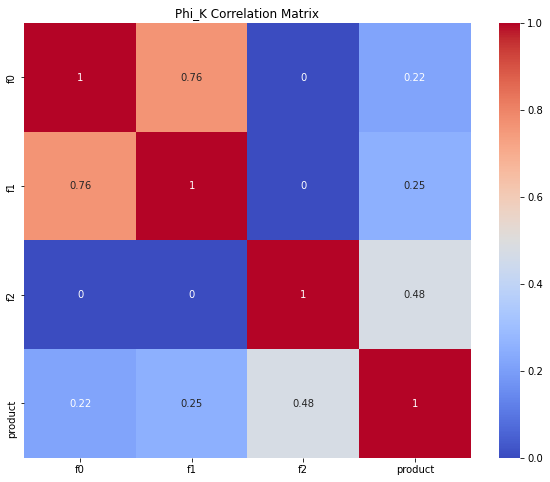

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_0, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

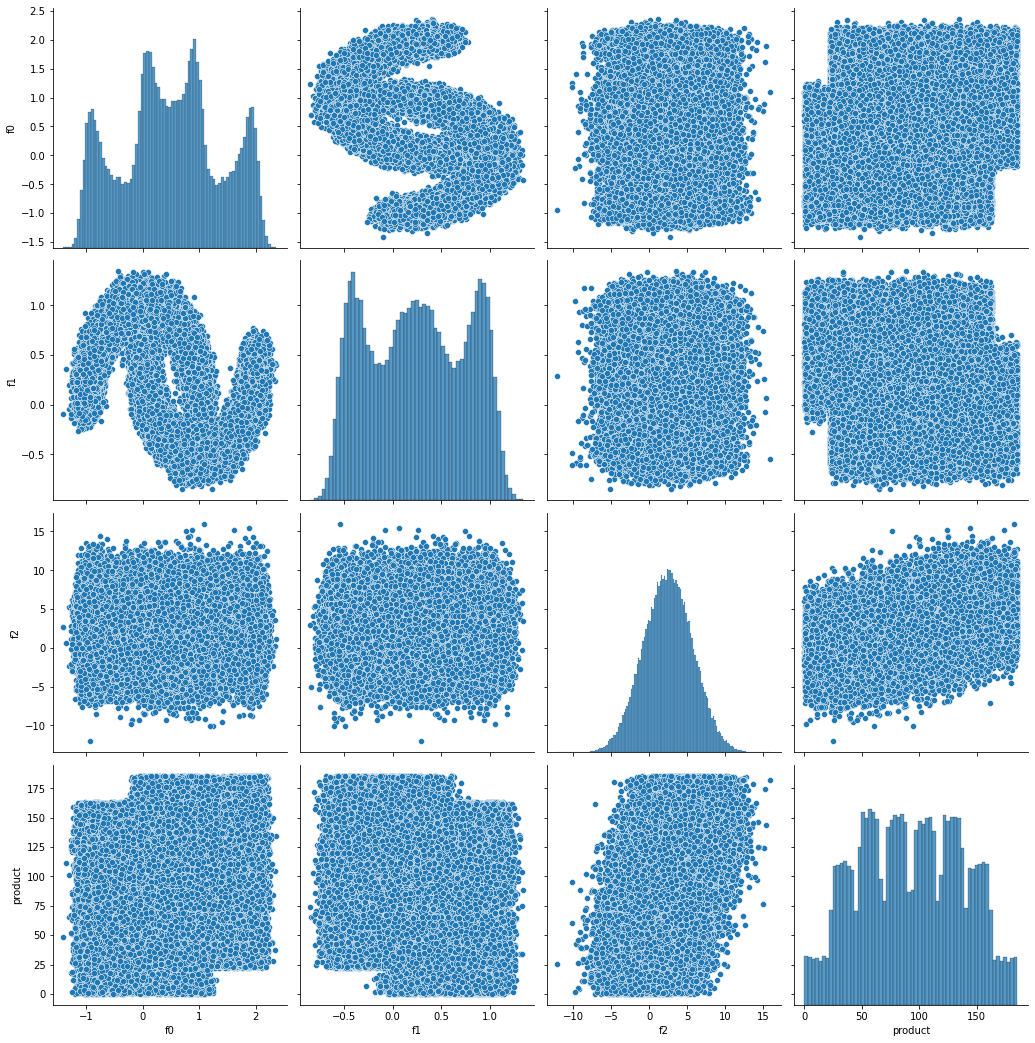

In [20]:
# изучим взаимосвязь между признаками: построим диаграммы рассеяния
sns.pairplot(data_0[['f0','f1','f2','product']])
plt.gcf().set_size_inches(15,15);

Можно отметить высокую корреляцию (0.76) между признаками f1 и f0. Только признак f2 имеет нормальное распределение. 

In [21]:
data_1_phik= data_1.drop('id', axis=1)
corr_matrix_1 = data_1_phik.phik_matrix(interval_cols=['f0','f1','f2','product'])

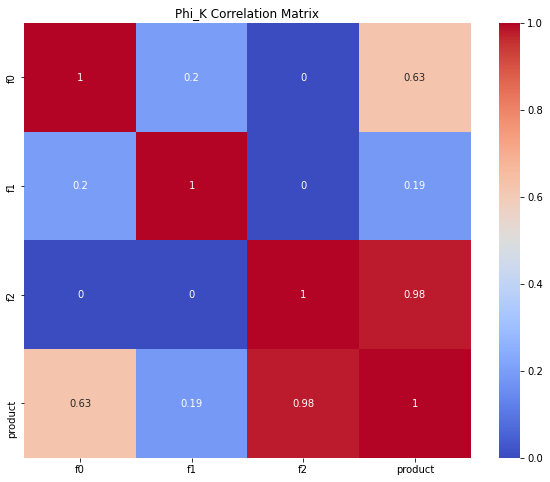

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_1, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

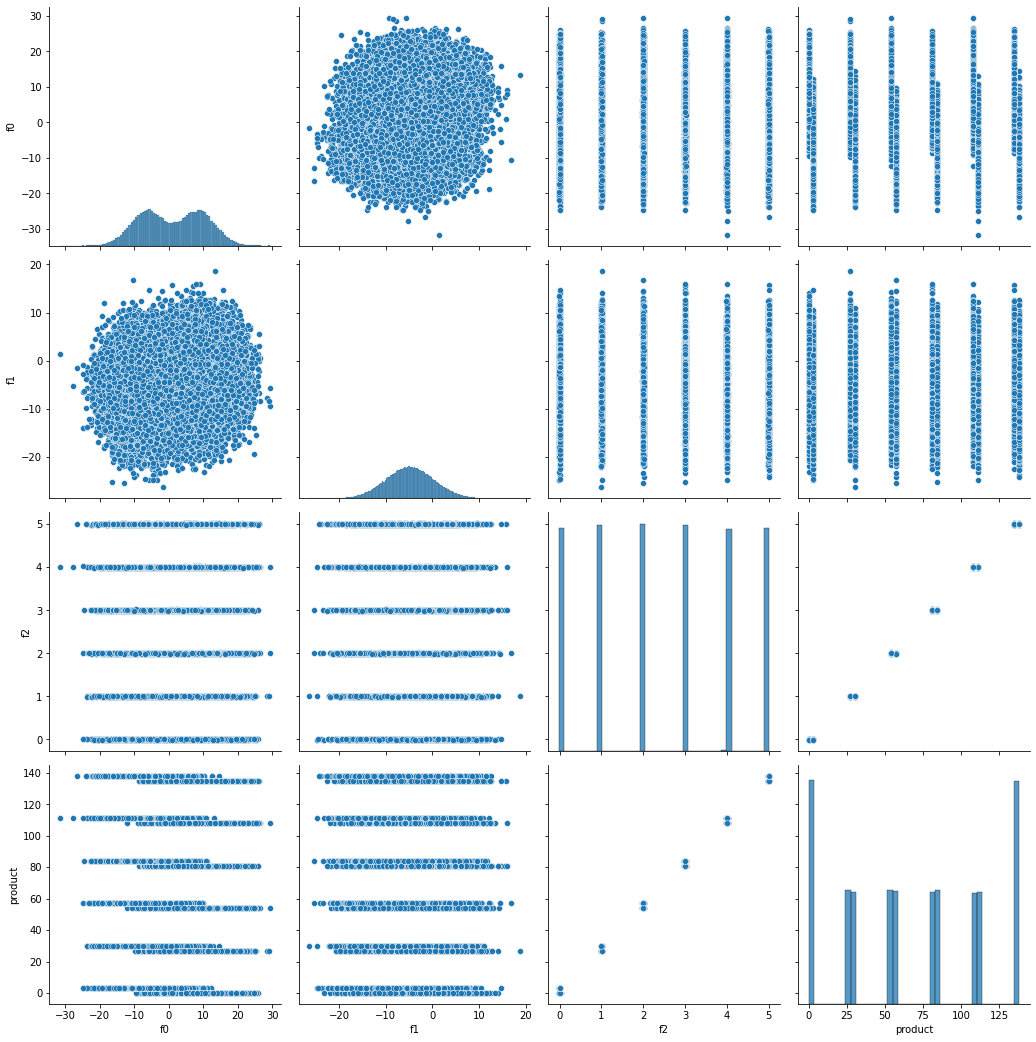

In [23]:
# изучим взаимосвязь между признаками: построим диаграммы рассеяния
sns.pairplot(data_1[['f0','f1','f2','product']])
plt.gcf().set_size_inches(15,15);

Только признак f1 имеет нормальное распределение. У f2 высокая корреляция с product (0.98).

In [24]:
data_2_phik= data_2.drop('id', axis=1)
corr_matrix_2 = data_2_phik.phik_matrix(interval_cols=['f0','f1','f2','product'])

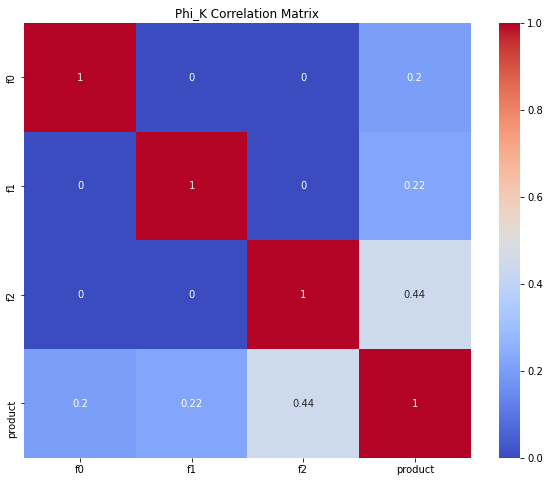

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_2, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

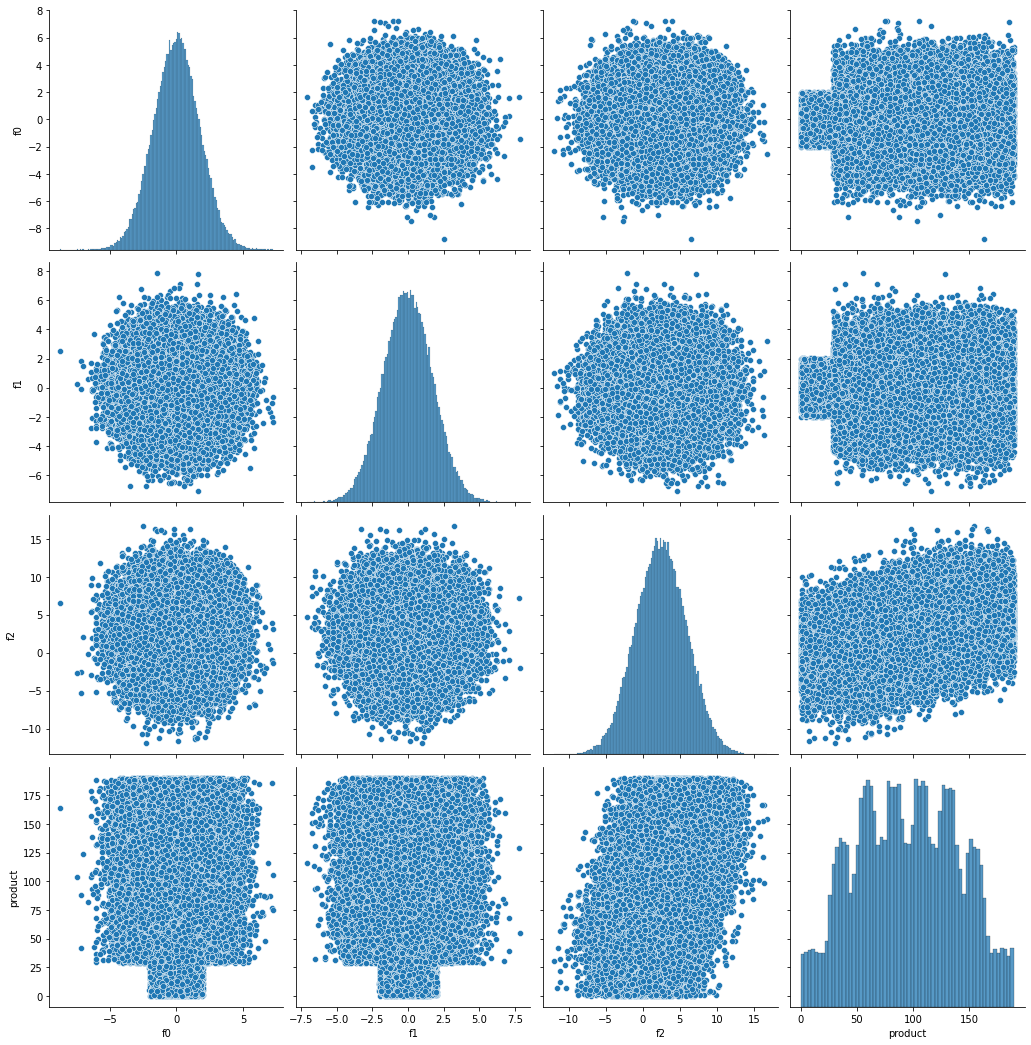

In [26]:
# изучим взаимосвязь между признаками: построим диаграммы рассеяния
sns.pairplot(data_2[['f0','f1','f2','product']])
plt.gcf().set_size_inches(15,15);

In [27]:
ydp.ProfileReport(data_0)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
ydp.ProfileReport(data_1)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
ydp.ProfileReport(data_2)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Признаки f0, f1 и f2 не имеют какую-либо взаимную зависимость.

Выводы:

В датафрейме data_0 100000 записей, названия столбцов адекватны содержащимся в них данным, в столбцах id тип данных object, f0, f1, f2, product тип данных float.

В датафрейме data_1 100000 записи, названия столбцов адекватны содержащимся в них данным, в столбцах id тип данных object, f0, f1, f2, product тип данных float.

В датафрейме data_2 100000 записей, названия столбцов адекватны содержащимся в них данным, в столбцах id тип данных object, f0, f1, f2, product тип данных float.

Были проверено, нет ли пропущенных значений; Было проверено наличие явных и неявных дубликатов. Неявные дубликаты были удалены.

У product высокая корреляция с f2 во втором наборе данных.

## Обучение и проверка модели

Отдельно определим данные с целевым признаком product и c признаками f1, f2, f3. Исключим из данных признак id.

In [30]:
# разбивка первого региона
features_0_region = data_0.drop(['id', 'product'], axis=1)
# разбивка второго региона
features_1_region = data_1.drop(['id', 'product'], axis=1)
# разбивка третьего региона
features_2_region = data_2.drop(['id', 'product'], axis=1)

target_0_region = data_0['product']
target_1_region = data_1['product']
target_2_region = data_2['product']

Разобъем данные на обучающую и валидационную выборки в соотношении 75:25.

In [31]:
# разбивка первого региона
features_0_train, features_0_valid, target_0_train, target_0_valid = train_test_split(
    features_0_region, target_0_region, test_size=0.25, random_state=RANDOM_STATE 
)
# разбивка второго региона
features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(
    features_1_region, target_1_region, test_size=0.25, random_state=RANDOM_STATE 
)
# разбивка третьего региона
features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(
    features_2_region, target_2_region, test_size=0.25, random_state=RANDOM_STATE
)

In [32]:
# проверем разбивки и выведем размеры выборок
display('Размер обучающей и валидационной выборки первого региона:')
display(features_0_train.shape, target_0_train.shape, features_0_valid.shape, target_0_valid.shape)
display('Размер обучающей и валидационной выборки второго региона:')
display(features_1_train.shape, target_1_train.shape, features_1_valid.shape, target_1_valid.shape)
display('Размер обучающей и валидационной выборки третьего региона:')
display(features_2_train.shape, target_2_train.shape, features_2_valid.shape, target_2_valid.shape)

'Размер обучающей и валидационной выборки первого региона:'

(74992, 3)

(74992,)

(24998, 3)

(24998,)

'Размер обучающей и валидационной выборки второго региона:'

(74997, 3)

(74997,)

(24999, 3)

(24999,)

'Размер обучающей и валидационной выборки третьего региона:'

(74997, 3)

(74997,)

(24999, 3)

(24999,)

In [33]:
# напишем общую функцию для масштабирования данных
def features_scale(features_train, features_valid):
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train_scale = scaler.transform(features_train)
    features_valid_scale = scaler.transform(features_valid)
    return features_train_scale, features_valid_scale

In [34]:
# масштабируем признаки первого региона
features_0_train, features_0_valid = features_scale(features_0_train, features_0_valid)
# масштабируем признаки второго региона
features_1_train, features_1_valid = features_scale(features_1_train, features_1_valid)
# масштабируем признаки третьего региона
features_2_train, features_2_valid = features_scale(features_2_train, features_2_valid)

In [35]:
# Для предсказания объема запасов нефти будет использована модель линейной регрессии
# напишем функцию для обучения модели и формирования общей сводной таблицы
def lr_model_predict(features_train, features_valid, target_train, target_valid): 
    lrmodel = LinearRegression()
    lrmodel.fit(features_train, target_train)
    predict = lrmodel.predict(features_valid)
    return pd.DataFrame({'Target':target_valid, 'Predict':predict})

# обучим модели и запишем данные по каждому региону
predict_0 = lr_model_predict(features_0_train, features_0_valid, target_0_train, target_0_valid)
predict_1 = lr_model_predict(features_1_train, features_1_valid, target_1_train, target_1_valid)
predict_2 = lr_model_predict(features_2_train, features_2_valid, target_2_train, target_2_valid)

# сформируем общую сводную таблицу и создадим датафрейм для заполнения
df_total = pd.DataFrame(
    columns=['Region', 'MSE', 'RMSE', 'R2', 'Real average oil reserves', 'Predicted average oil reserves']
)
i = 0
name_list = ['Регион №1', 'Регион №2', 'Регион №3']
for name, data in zip(name_list, (predict_0, predict_1, predict_2)):
    df_total.loc[i, 'Region'] = name
    mse = mean_squared_error(data['Target'], data['Predict'])
    df_total.loc[i, 'MSE'] = mse
    df_total.loc[i, 'RMSE'] = mse**0.5
    df_total.loc[i, 'R2'] = r2_score(data['Target'], data['Predict'])
    df_total.loc[i, 'Real average oil reserves'] = data['Target'].mean()
    df_total.loc[i, 'Predicted average oil reserves'] = data['Predict'].mean()
    i += 1
    
# выведем общую таблицу
display(df_total)

Region          MSE       RMSE        R2 Real average oil reserves  \
0  Регион №1  1420.165953  37.685089  0.274539                 92.388766   
1  Регион №2     0.797139   0.892827  0.999623                 68.583616   
2  Регион №3  1606.472327  40.080822  0.194846                 95.254637   

  Predicted average oil reserves  
0                       92.60984  
1                      68.577035  
2                      94.934787

Вывод:

По региону 2 модель линейной регрессии предсказала почти 100% результат по объемам запасов нефти на валидационной выборке (метрика R2 равна 0.99). Прогнозируемый средний запас объемов нефти по региону 2 самый низкий и составляет 68.58 тыс.бар.

По регионам 1 и 3 можно наблюдать больший прогнозируемый объем запасов, но и ошибка значительно выше.

Регион 3 имеет самый большой прогнозируемый средний запас объемов нефти (94,9 тыс.бар.), на втором месте регион №1 (92,6 тыс.бар.).

## Подготовка к расчёту прибыли

In [36]:
#для всех ключевых значений создадим константы
BUDGET = 10_000_000_000
BARREL_INCOME = 450_000
PROBABILITY_OF_LOSSES = 0.025
TOP_200 = 200
BUDGET_FOR_ONE = BUDGET/TOP_200
print(BUDGET_FOR_ONE)

50000000.0


Задача - разработать 200 скважин в регионе, а значит на разработку каждой скважины требуется 50 млн. Таким образом, для разработки подходят скважины, имеющие нефть, суммарная стоимость которой превышает 50 млн. руб.

In [37]:
print('Средний объем нефти в 1 регионе', target_0_region.mean())
print('Средний объем нефти в 2 регионе', target_1_region.mean())
print('Средний объем нефти в 3 регионе', target_2_region.mean())

Средний объем нефти в 1 регионе 92.49968421774354
Средний объем нефти в 2 регионе 68.82391591804064
Средний объем нефти в 3 регионе 94.99834211933378


Определим минимальное достаточное количество нефти для окупаемости скважины.

In [38]:
MIN_BARREL_NEED = BUDGET_FOR_ONE/BARREL_INCOME
MIN_BARREL_NEED

111.11111111111111

Для безубыточной разработки каждой скважины необходимо, чтобы объем запасов сырья составлял не менее 111.11 тысяч баррелей. Можно сделать вывод что ни один регион не являтся прибыльным, но выберем 200 лучших скважин с самым большим прогнозируемым объемом запаса нефти.

Расчет прибыли региона будет высчитываться по формуле:

прибыль = кол-во тыс. баррелей добытых в регионе * стоимость 1 тыс. баррелей - бюджет затраченный на разработку скважин в регионе

In [39]:
def revenue(target_valid, predictions_valid):
    # выберем 200 лучших скважин с самым большим прогнозируемым объемом запаса нефти
    best_pred = predictions_valid.sort_values(ascending=False)[:TOP_200]
    # определим для выбранных скажин реальный объем запасов
    best_pred = target_valid[best_pred.index].head(200)
    # расчитаем валовую прибыль
    return (best_pred.sum() * BARREL_INCOME - BUDGET)

## Расчёт прибыли и рисков 

Отсортируем предсказания по убыванию. Посчитаем суммарное кол-во нефти в них и прибыль которую они могу принести.

In [40]:
#расчитаем максимальную валовую прибыль с каждого региона и запишем данные в общую таблицу
df_total.loc[0, 'Best Revenue'] = revenue(predict_0['Target'], predict_0['Predict']).round(2)
df_total.loc[1, 'Best Revenue'] = revenue(predict_1['Target'], predict_1['Predict']).round(2)
df_total.loc[2, 'Best Revenue'] = revenue(predict_2['Target'], predict_2['Predict']).round(2)

In [41]:
print('Ожидаемая валовая прибыль по первому региону при разработке 200 скважин: {} тыс. руб.'.format(
    df_total.loc[0, 'Best Revenue']))
print('Ожидаемая валовая прибыль по второму региону при разработке 200 скважин: {} тыс. руб.'.format(
    df_total.loc[1, 'Best Revenue']))
print('Ожидаемая валовая прибыль по третьему региону при разработке 200 скважин: {} тыс. руб.'.format(
    df_total.loc[2, 'Best Revenue']))

Ожидаемая валовая прибыль по первому региону при разработке 200 скважин: 3468529787.42 тыс. руб.
Ожидаемая валовая прибыль по второму региону при разработке 200 скважин: 2415086696.68 тыс. руб.
Ожидаемая валовая прибыль по третьему региону при разработке 200 скважин: 2396613000.94 тыс. руб.


Наибольшую валовую прибыль при разработке 200 скважин можно ожидать в первом регионе, которая составит 3468529787.42 тыс. руб. 

In [42]:
# напишем функцию подсчета прибыли с Bootstrap из 1000 выборок 
random_state = np.random.RandomState()
def sample_bootstrap(data):
    samples = []
    for i in range(0, 1000):
        sample = data.sample(n=500, replace=True, random_state=random_state)
        samples.append(revenue(sample['Target'], sample['Predict']))
        subsamples_revenue = pd.Series(samples)
    return subsamples_revenue 

In [43]:
revenue_one_regions = sample_bootstrap(predict_0)
revenue_two_regions = sample_bootstrap(predict_1)
revenue_three_regions = sample_bootstrap(predict_2)

i = 0
for data in (revenue_one_regions, revenue_two_regions, revenue_three_regions):
    mean_revenue = data.mean().round(2)
    lower = data.quantile(0.025).round(2)
    upper = data.quantile(0.975).round(2)
    risk = st.percentileofscore(data, 0)
    
    print(f'Средняя валовая прибыль по региону №{i+1} составит: {mean_revenue} тыс.руб.')
    print(f'95%-й доверительный интервал составит: {lower}-{upper} тыс.руб.')
    print(f'Риск убытков: {risk:.2f} %')
    print('---------------------------------------')
    
    # запишем данные в общую таблицу
    df_total.loc[i, 'Average Revenue'] = mean_revenue
    df_total.loc[i, '95% confidence interval'] = str(lower) + '-' + str(upper)
    df_total.loc[i, 'Risk'] = risk  
    i +=1

Средняя валовая прибыль по региону №1 составит: 437806577.73 тыс.руб.
95%-й доверительный интервал составит: -125378923.23-1009214149.42 тыс.руб.
Риск убытков: 6.20 %
---------------------------------------
Средняя валовая прибыль по региону №2 составит: 492421061.01 тыс.руб.
95%-й доверительный интервал составит: 83116987.16-962933627.06 тыс.руб.
Риск убытков: 1.10 %
---------------------------------------
Средняя валовая прибыль по региону №3 составит: 392674267.45 тыс.руб.
95%-й доверительный интервал составит: -172621988.58-940578485.82 тыс.руб.
Риск убытков: 7.30 %
---------------------------------------


Второй регион имеет потенциал в плане нахождения и разработки 200 скважин, имеющих наибольшие запасы (ожидаемая валовая прибыль по вервому региону при разработке 200 скважин: 500639835.96 тыс.руб. при самом низком риске убытков: 0.80 %).

In [44]:
df_total

Region          MSE       RMSE        R2 Real average oil reserves  \
0  Регион №1  1420.165953  37.685089  0.274539                 92.388766   
1  Регион №2     0.797139   0.892827  0.999623                 68.583616   
2  Регион №3  1606.472327  40.080822  0.194846                 95.254637   

  Predicted average oil reserves  Best Revenue  Average Revenue  \
0                       92.60984  3.468530e+09     4.378066e+08   
1                      68.577035  2.415087e+09     4.924211e+08   
2                      94.934787  2.396613e+09     3.926743e+08   

       95% confidence interval  Risk  
0  -125378923.23-1009214149.42   6.2  
1     83116987.16-962933627.06   1.1  
2   -172621988.58-940578485.82   7.3

Вывод:

Данные были подготовлены и проверены на наличие дубликатов и пропусков. В датафрейме data_0 100000 записей, названия столбцов адекватны содержащимся в них данным, в столбцах id тип данных object, f0, f1, f2, product тип данных float. В датафрейме data_1 100000 записи, названия столбцов адекватны содержащимся в них данным, в столбцах id тип данных object, f0, f1, f2, product тип данных float. В датафрейме data_2 100000 записей, названия столбцов адекватны содержащимся в них данным, в столбцах id тип данных object, f0, f1, f2, product тип данных float. Были проверено, нет ли пропущенных значений; Было проверено наличие явных и неявных дубликатов. Неявные дубликаты были удалены. Выявлено, что у product высокая корреляция с f2 во втором наборе данных.

Данные были разбиты на обучающую и валидационную выборку в соотношении 75:25. Для предсказания объема запасов нефти была использована модель линейной регрессии. Рассчитано среднеквадратичное отклонение предсказаний от валидационной выборки. Выявлено, что по региону 2 модель линейной регрессии предсказала почти 100% результат по объемам запасов нефти на валидационной выборке (метрика R2 равна 0.99). Прогнозируемый средний запас объемов нефти по региону 2 самый низкий и составляет 68.58 тыс.бар.По регионам 1 и 3 можно наблюдать больший прогнозируемый объем запасов, но и ошибка значительно выше. Все модели имеют метрику R2 > 0, что говорит об адекватности их прогнозирования в сравнении с константными моделями, предсказывающими среднее значение по каждой выборке. Регион 3 имеет самый большой прогнозируемый средний запас объемов нефти (94,9 тыс.бар.), на втором месте регион №1 (92,6 тыс.бар.).

Написана функция расчета прибыли и Bootstrap. Процедурой Bootstrap выборки были разбиты по 500 значений, из этих 500 выбраны 200 с наибольшим показателем объема нефти в скважине. Расчитан суммарный доход, подсчитана прибыль. Расчитана средняя прибыль в регионе, доверительный интервал и риск убытков. Средняя валовая прибыль по региону №1 составит: 441083810.39 тыс.руб.
95%-й доверительный интервал составит: -77249971.55-975735797.94 тыс.руб. Риск убытков: 5.40 %. Средняя валовая прибыль по региону №2 составит: 500639835.96 тыс.руб. 95%-й доверительный интервал составит: 85239556.47-937210886.07 тыс.руб.Риск убытков: 0.80 %. Средняя валовая прибыль по региону №3 составит: 398587359.47 тыс.руб. 95%-й доверительный интервал составит: -182652716.89-931716279.77 тыс.руб. Риск убытков: 8.30 %.

Таким образом, по результатам работы можно рекомендовать вложить бюджет в развитие добычи в 2 регионе, т.к второй регион имеет потенциал в плане нахождения и разработки 200 скважин, имеющих наибольшие запасы (ожидаемая валовая прибыль по вервому региону при разработке 200 скважин: 500639835.96 тыс.руб. при самом низком риске убытков: 0.80 %).

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован